<a href="https://colab.research.google.com/github/ncorriveau/ood_computervision/blob/main/superclass_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [ ]:
!pip install --upgrade torchvision==0.13

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil 

In [ ]:
try:
  import timm
except:
  !pip install timm
  import timm

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.cuda.empty_cache()

###Set up data and helper functions

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive') 
  train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
  test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'
  base_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/models/'

except:
  train_path = '/content/train'
  test_path = '/content/test'
  base_path = '/content/models'

In [ ]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# !unzip /content/train.zip
# !unzip /content/test.zip
# !unzip /content/models.zip

In [ ]:
weights_resnet = torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT
vit_weights = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# weights
#weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT
res_t = weights_resnet.transforms()
vit_t = vit_weights.transforms()
print(f"Resnet transforms: {res_t}\n Vit transforms {vit_t}")

Resnet transforms: ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
 Vit transforms ImageClassification(
    crop_size=[224]
    resize_size=[242]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                               test_dir=test_path,
                                                                               transform=res_t, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe1a6523210>,
 ['bird', 'dog', 'reptile'])

In [ ]:
from typing import Tuple
def test_model(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

class EarlyStopper:
  '''creates a class that tracks validation loss -
  the parameters 'patience' determines how long you can have a validation loss
  that is greater than min validation loss + delta'''
  def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          save_path:str,
          early_stop: False) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    
    adding that the training loop saves the best performing weights and 
    early stopping 
    """
    import copy

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)
    min_loss = np.Inf
    
    #instantiate early stopper 
    if early_stop:
      early_stopper = EarlyStopper(patience=3, min_delta=0.2)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        

        if early_stop:
          if early_stopper.early_stop(test_loss):
            break

        if test_loss < min_loss:
          min_loss = test_loss
          best_model_state = copy.deepcopy(model.classifier.state_dict()) 
          torch.save(model.classifier.state_dict(), save_path) #model.heads is specific to ViT

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(loss_hist, acc_hist):
    """Plots training curves of a loss and accuracy dicts. 
    Args:
       loss_hist = {train_loss:[], val_loss:[]}
       train_hist = {train_acc:[], val_acc:[]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = loss_hist['train']
    test_loss = loss_hist['val']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = acc_hist['train']
    test_accuracy = acc_hist['val']

    # Figure out how many epochs there were
    epochs = range(len(loss_hist['train']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

###Create and run ensemble classifier

In [ ]:
class EnsembleModelAll(nn.Module):   
  '''
  ensemble class will take three models and use their input to classify
  the superclass by learning the right weights between the three models
  in our case, this wil be a ResNet50, ViT, and EfficientNet as the three 
  CV models. 

  So each incoming feature vector will be a 3x1, and we will have three of them.
  The output will be a 3x1 
  softmax vector of the super classes 
  '''

  def __init__(self, modelA, modelB, modelC):
    super().__init__()
    self.modelA = modelA
    self.modelB = modelB
    self.modelC = modelC
    self.classifier = nn.Linear(3 * 3, 3)
        
  def forward(self, x):
    x1 = self.modelA(x)
    x2 = self.modelB(x)
    x3 = self.modelC(x)
    x = torch.cat((x1, x2, x3), dim=1)
    out = self.classifier(x)
    return out
    

In [ ]:
#initialize ensemble modles 
weights_resnet = torchvision.models.ResNet50_Weights.DEFAULT.DEFAULT
resnet_model = torchvision.models.resnet50(weights=weights_resnet)
in_ftrs = resnet_model.fc.in_features
out_fts = 3
resnet_model.fc = nn.Linear(in_ftrs, out_fts)
resnet_model.load_state_dict(torch.load('/content/models/resnet_50.pth'))
resnet_model.eval()

resnet_model.to(device)


In [ ]:
weights_vit = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

vit_model = torchvision.models.vit_l_16(weights=weights_vit)
vit_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, 
                    out_features=3, # same number of output units as our number of classes
                    bias=True))
vit_model.heads.load_state_dict(torch.load('/content/models/vit_l_16_classifier.pth'))
vit_model.eval()

vit_model.to(device)
#test_model(vit_model, test_dataloader, nn.CrossEntropyLoss(), device=device)

In [ ]:
weights_en = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
en_model = torchvision.models.efficientnet_v2_s(weights=weights_en)
en_model.classifier[1] = nn.Linear(1280, 3)
en_model.load_state_dict(torch.load('/content/models/efficientnet_v2_s.pth'))
en_model.eval() 

en_model.to(device)
#test_model(en_model, test_dataloader, nn.CrossEntropyLoss(), device=device)

In [ ]:
#train ensemble 
ensemble_model = EnsembleModelAll(resnet_model, vit_model, en_model)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(device)

In [ ]:
summary(model=ensemble_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model.classifier.parameters(), lr=0.001)

In [ ]:
#train ensemble model 
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
# Setup training and save the results
results = train(model=ensemble_model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50,
                device=device,
                save_path='/content/models/ensemble_3_best.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
def plot_loss_curves(loss_hist, acc_hist):
    """Plots training curves of a loss and accuracy dicts. 
    Args:
       loss_hist = {train_loss:[], val_loss:[]}
       train_hist = {train_acc:[], val_acc:[]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = loss_hist['train']
    test_loss = loss_hist['val']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = acc_hist['train']
    test_accuracy = acc_hist['val']

    # Figure out how many epochs there were
    epochs = range(len(loss_hist['train']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
loss_hist = {"train": ensemble_results["train_loss"], "val": ensemble_results["test_loss"]}
acc_hist = {"train": ensemble_results["train_acc"], "val": ensemble_results["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
#test_model(vit_model, test_dataloader, nn.CrossEntropyLoss(), device=device)

In [ ]:
#test_model(resnet_model, test_dataloader, nn.CrossEntropyLoss(), device=device)

###Reduce Ensemble to two

In [ ]:
class EnsembleModelTwo(nn.Module):   
  '''
  ensemble class will take two models this time and use their input to classify
  the superclass by learning the right weights between the two models
  in our case, this wil be a ResNet50 and Vit.

  So each incoming feature vector will be a 3x1, and we will have two of them.
  The output will be a 3x1 
  softmax vector of the super classes 
  '''

  def __init__(self, modelA, modelB):
    super().__init__()
    self.modelA = modelA
    self.modelB = modelB
    self.classifier = nn.Linear(2 * 3, 3)
        
  def forward(self, x):
    x1 = self.modelA(x)
    x2 = self.modelB(x)
    x = torch.cat((x1, x2), dim=1)
    out = self.classifier(x)
    return out

In [ ]:
#train ensemble 
ensemble_model_2 = EnsembleModelTwo(resnet_model, vit_model)

for param in ensemble_model_2.parameters():
    param.requires_grad = False

for param in ensemble_model_2.classifier.parameters():
    param.requires_grad = True    

ensemble_model_2 = ensemble_model_2.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model_2.classifier.parameters(), lr=0.001)

In [ ]:
#train ensemble model 
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
# Setup training and save the results
results = train(model=ensemble_model_2,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device,
                save_path='/content/models/ensemble_2_best.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

loss_hist = {"train": results["train_loss"], "val": results["test_loss"]}
acc_hist = {"train": results["train_acc"], "val": results["test_acc"]}

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0129 | train_acc: 0.4983 | test_loss: 0.9572 | test_acc: 0.5717
Epoch: 2 | train_loss: 0.9565 | train_acc: 0.5551 | test_loss: 0.9035 | test_acc: 0.6073
Epoch: 3 | train_loss: 0.9324 | train_acc: 0.5659 | test_loss: 0.8808 | test_acc: 0.6145
Epoch: 4 | train_loss: 0.9088 | train_acc: 0.5816 | test_loss: 0.8571 | test_acc: 0.6185
Epoch: 5 | train_loss: 0.9060 | train_acc: 0.5711 | test_loss: 0.8478 | test_acc: 0.6192
Epoch: 6 | train_loss: 0.9024 | train_acc: 0.5776 | test_loss: 0.8491 | test_acc: 0.6150
Epoch: 7 | train_loss: 0.9001 | train_acc: 0.5750 | test_loss: 0.8464 | test_acc: 0.6136
Epoch: 8 | train_loss: 0.8980 | train_acc: 0.5859 | test_loss: 0.8342 | test_acc: 0.6241
Epoch: 9 | train_loss: 0.9033 | train_acc: 0.5737 | test_loss: 0.8361 | test_acc: 0.6196
Epoch: 10 | train_loss: 0.8895 | train_acc: 0.5851 | test_loss: 0.8307 | test_acc: 0.6228
[INFO] Total training time: 10075.311 seconds


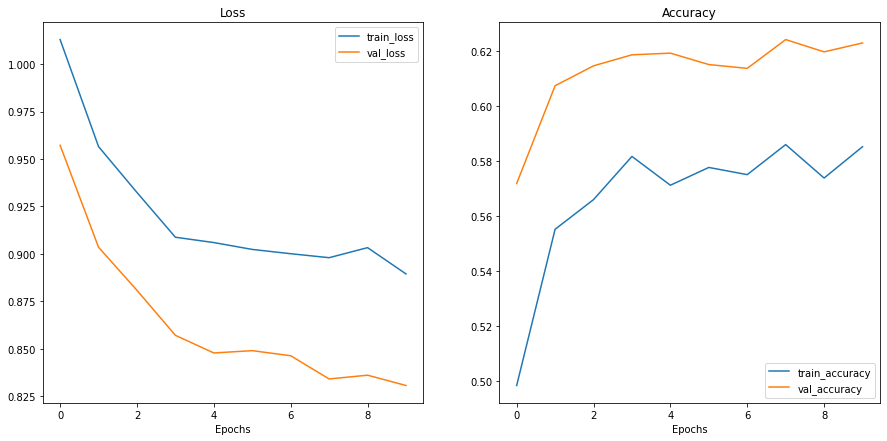

In [ ]:
plot_loss_curves(loss_hist, acc_hist)

###Optimize Classifier

In [ ]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

In [ ]:
MODEL = ensemble_model
EPOCHS = 5
DEVICE = device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader = train_dataloader
valid_loader = test_dataloader

def objective(trial):

    # Generate the model.
    model = MODEL

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    #batch_size=trial.suggest_int("batch_size", 16, 128,step=16)

    criterion=nn.CrossEntropyLoss()
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
#create study for optuna 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

end_time = timer()
print(f"[INFO] Total time to tune hyper parameters: {end_time-start_time:.3f} seconds using {DEVICE}")

df = study.trials_dataframe()
df

[I 2022-12-12 01:51:39,567] A new study created in memory with name: no-name-695cddb1-5280-456b-8ece-c26790c5559e
[I 2022-12-12 03:29:00,249] Trial 0 finished with value: 0.4346415327564895 and parameters: {'optimizer': 'SGD', 'lr': 0.03436145355133335}. Best is trial 0 with value: 0.4346415327564895.
[I 2022-12-12 05:06:23,367] Trial 1 finished with value: 0.42629789864029666 and parameters: {'optimizer': 'Adam', 'lr': 3.515118469905006e-05}. Best is trial 0 with value: 0.4346415327564895.
[I 2022-12-12 06:43:27,693] Trial 2 finished with value: 0.43170580964153277 and parameters: {'optimizer': 'SGD', 'lr': 5.407498153361748e-05}. Best is trial 0 with value: 0.4346415327564895.


Accuracy: 0.4346415327564895
Best hyperparameters: {'optimizer': 'SGD', 'lr': 0.03436145355133335}
[INFO] Total time to tune hyper parameters: 17508.130 seconds using cuda


,number,value,datetime_start,datetime_complete,duration,params_lr,params_optimizer,state
0,0,0.434642,2022-12-12 01:51:39.570247,2022-12-12 03:29:00.248723,0 days 01:37:20.678476,0.034361,SGD,COMPLETE
1,1,0.426298,2022-12-12 03:29:00.251812,2022-12-12 05:06:23.367184,0 days 01:37:23.115372,0.000035,Adam,COMPLETE
2,2,0.431706,2022-12-12 05:06:23.370726,2022-12-12 06:43:27.693323,0 days 01:37:04.322597,0.000054,SGD,COMPLETE
